<a href="https://colab.research.google.com/github/VVadeNuuti/SmartContractVulnerabilities/blob/main/DistilBert_With_Trained_Tokenizer_for_Smart_Contract_Vulnerabilities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up the data

To downoad files from Drive, change the download url from https://drive.google.com/file/d/'id'/view?usp=sharing to https://drive.google.com/uc?id= followed by the id part of the link

In [1]:
!gdown https://drive.google.com/uc?id=1AZ7mQ134qCgJAbou6em_UXcV4Yy-GJCV

Downloading...
From: https://drive.google.com/uc?id=1AZ7mQ134qCgJAbou6em_UXcV4Yy-GJCV
To: /content/code_changes_labeled.zip
100% 591k/591k [00:00<00:00, 75.7MB/s]


In [2]:
!gdown https://drive.google.com/uc?id=1BZGyV3k71s-JD0eIg3v_88Zl37CWcddv

Downloading...
From: https://drive.google.com/uc?id=1BZGyV3k71s-JD0eIg3v_88Zl37CWcddv
To: /content/model_distilbert_92_validation.zip
100% 247M/247M [00:03<00:00, 67.3MB/s]


### Unzipping the downloaded dataset and model

In [3]:
!unzip '/content/code_changes_labeled.zip'

Archive:  /content/code_changes_labeled.zip
  inflating: code_changes_labeled.xlsx  


In [4]:
!unzip '/content/model_distilbert_92_validation.zip'

Archive:  /content/model_distilbert_92_validation.zip
   creating: content/model_save/model_distilbert_92_validation/
  inflating: content/model_save/model_distilbert_92_validation/vocab.txt  
  inflating: content/model_save/model_distilbert_92_validation/pytorch_model.bin  
  inflating: content/model_save/model_distilbert_92_validation/config.json  
  inflating: content/model_save/model_distilbert_92_validation/special_tokens_map.json  
  inflating: content/model_save/model_distilbert_92_validation/tokenizer.json  
  inflating: content/model_save/model_distilbert_92_validation/tokenizer_config.json  


In [5]:
import os
import pandas as pd
df = pd.read_excel('/content/code_changes_labeled.xlsx', names=["code", "label"], na_filter=False)

Make directories to save the data into

In [6]:
import os
os.mkdir('/content/text_files')
os.mkdir('/content/text_files/all')

In [7]:
os.mkdir('/content/text_files/all/pos')
os.mkdir('/content/text_files/all/neg')

## Go through the dataset and write the code into text files

In [8]:
i=0
for index, row in df.iterrows():
    if i > len(df):
       break
    else:
      if df['label'][index] == 0:
        f = open('/content/text_files/all/neg/'+str(i)+'.txt', 'w', encoding='utf-8')
        f.write(row[0])
        f.close()
        i+=1
      else:
        f = open('/content/text_files/all/pos/'+str(i)+'.txt', 'w', encoding='utf-8')
        f.write(row[0])
        f.close()
        i+=1

Splitting the dataset into training, validation and testing sets

In [9]:
from pathlib import Path

def read_imdb_split(split_dir):
    split_dir = Path(split_dir)
    texts = []
    labels = []
    for label_dir in ["pos", "neg"]:
        for text_file in (split_dir/label_dir).iterdir():
            texts.append(text_file.read_text())
            labels.append(0 if label_dir is "neg" else 1)

    return texts, labels

train_texts, train_labels = read_imdb_split('/content/text_files/all')

<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-9-d5c145369ffb>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
  labels.append(0 if label_dir is "neg" else 1)


##Installing the transformers library from HuggingFace

In [10]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.7 MB/s eta 0:00:00


### Set the tokenizer and model that will be used. The Auto functions from the transformers library recognize the type of model and set it automatically.

In [11]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import torch
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("/content/content/model_save/model_distilbert_92_validation")
model = AutoModelForSequenceClassification.from_pretrained("/content/content/model_save/model_distilbert_92_validation")

# The training loop and setting up the dataset

### Reshuffling the dataset

In [44]:
from pathlib import Path

# Read the files in the data folder

def read_data_split(split_dir):
    split_dir = Path(split_dir)
    texts = []
    labels = []
    for label_dir in ["pos", "neg"]:
        for text_file in (split_dir/label_dir).iterdir():
            texts.append(text_file.read_text())
            labels.append(0 if label_dir is "neg" else 1)

    return texts, labels

train_texts, train_labels = read_data_split('/content/text_files/all')

<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-44-d596800dbda7>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  labels.append(0 if label_dir is "neg" else 1)


In [45]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, train_size=.7, shuffle=True) # Split the full dataset into two segments, 70% for training and 30% for testing
val_texts, test_texts, val_labels, test_labels = train_test_split(val_texts, val_labels, test_size=.5, shuffle=True) # Split the 30% to two sets, test and validation

# Encode the split dataset with the tokenizer
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [46]:
import torch

# Take the encoded data and put in Dataset form that the model can use
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, train_labels)
val_dataset = Dataset(val_encodings, val_labels)
test_dataset = Dataset(test_encodings, test_labels)

### Training loops


In [15]:
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW
from transformers import AutoModelForSequenceClassification

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the model for Sequence Classification
model = AutoModelForSequenceClassification.from_pretrained('/content/content/model_save/model_distilbert_92_validation')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) # Batch size is 16 to limit errors due to running out of memory

optim = AdamW(model.parameters(), lr=1e-8) # Original learning rate as 5e-5, recuded after some training was done

for epoch in range(1):
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        optim.zero_grad()

        loop.set_description(f'Epoch: {epoch}')
        loop.set_postfix(loss=loss.item())
model.eval()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/128 [00:00<?, ?it/s]

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

### A a second training loop to continue training without saving and loading the model

In [16]:
optim = AdamW(model.parameters(), lr=1e-8)

for epoch in range(1):
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        optim.zero_grad()

        loop.set_description(f'Epoch: {epoch}')
        loop.set_postfix(loss=loss.item())

  0%|          | 0/128 [00:00<?, ?it/s]

In [17]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/model_save/model_test_save'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to /content/model_save/model_test_save


('/content/model_save/model_test_save/tokenizer_config.json',
 '/content/model_save/model_test_save/special_tokens_map.json',
 '/content/model_save/model_test_save/vocab.txt',
 '/content/model_save/model_test_save/added_tokens.json',
 '/content/model_save/model_test_save/tokenizer.json')

## Validation and testing

In [47]:
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [48]:
val_loader = DataLoader(val_dataset, batch_size=16)

In [49]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn import metrics
import numpy
import matplotlib.pyplot as plt

def validation(validation_dataloader):
  with torch.no_grad():
    loss_val_list = []
    preds_list = []
    accuracy_list = []
    targets_list = []
    predictions_list = []
    accuracy_sum = 0
    for batch in tqdm(validation_dataloader):
      #print(batch.keys())
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
      loss = outputs[0]
      logits = F.softmax(outputs[1], dim=1)   # Taking the softmax of output
      _,preds = torch.max(logits, dim=1)      # Taking the predictions of our batch
      acc = accuracy(logits,labels)           # Calculating the accuracy of current batch
      accuracy_sum += acc                     # Taking sum of all the accuracies of all the batches. This sum will be divided by batch length to get mean accuracy for validation dataset

      loss_val_list.append(loss)
      preds_list.append(preds)
      accuracy_list.append(acc)

      for label in labels.cpu().data.numpy():
        targets_list.append(label)
      for prediction in preds.cpu().data.numpy():
        predictions_list.append(prediction)

  mean_accuracy = accuracy_sum / len(validation_dataloader)
  print(targets_list)
  print(predictions_list)
  precision = precision_score(targets_list, predictions_list, average='binary')
  precision_str = "Precision: " + str(precision)
  recall = recall_score(targets_list, predictions_list, average='binary')
  recall_str = "Recall: " + str(recall)
  f1 = f1_score(targets_list, predictions_list, average='binary')
  f1_str = "F1: " + str(f1)
  confusion_matrix = metrics.confusion_matrix(targets_list, predictions_list)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
  cm_display.plot()
  plt.show()
  return mean_accuracy, precision_str, recall_str, f1_str

  0%|          | 0/28 [00:00<?, ?it/s]

[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 

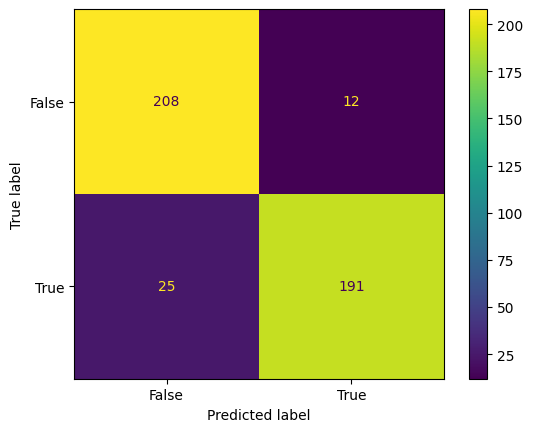

(tensor(0.9174),
 'Precision: 0.9408866995073891',
 'Recall: 0.8842592592592593',
 'F1: 0.9116945107398569')

In [51]:
validation(val_loader)

In [52]:
test_loader = DataLoader(test_dataset, batch_size=16)

  0%|          | 0/28 [00:00<?, ?it/s]

[1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 

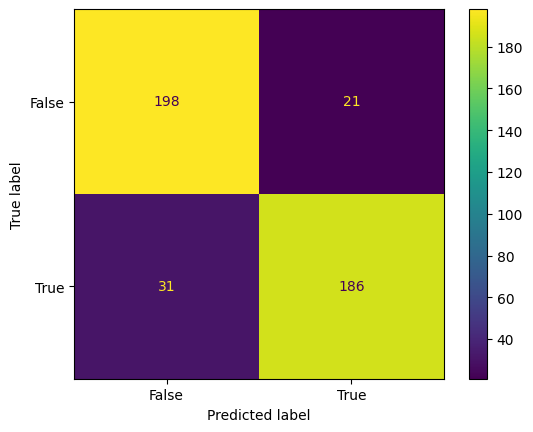

(tensor(0.8839),
 'Precision: 0.8985507246376812',
 'Recall: 0.8571428571428571',
 'F1: 0.8773584905660375')

In [53]:
validation(test_loader)

## Testing the model with user input. The data is loaded in a similar way as it is for the training, just from singular inputs outside of the dataset

#### Multiline strings. ' ' Around each line, with a comma after each line

In [25]:
multiline_str_after = ''.join((
     '/** Constructor */',
 '',
    'constructor(address _storageAddress) public StablePayStorage(_storageAddress) {',
         'version = 1;',
     '}',
 '',
     '/** Methods */',
 '',
    'function _isSwappingProviderNewOrUpdate(bytes32 _providerKey, address _owner)',
         'public',
         'view',
         'isSwappingProviderNewOrUpdate(_providerKey, _owner)'
))

multiline_str_before = ''.join((
          'pragma solidity ^0.6.8;',
          '',
          'import { LibEIP712Domain } from "./EIP712.sol";',
))


code_string =  ' (out, ars, errors) = _mv(params, flags, wd, arg_list, sb.get_inode_count(inodes), inodes, data);'

review = [multiline_str_after]


#### Loading the data for testing

In [26]:
review_tokenised = tokenizer(review, truncation=True, padding=True)

In [27]:
review_dataset = Dataset(review_tokenised, [0])

In [28]:
review_loader = DataLoader(review_dataset, batch_size=1)

In [29]:
with torch.no_grad():
  for batch in review_loader : 
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    prediction = model(input_ids, attention_mask=attention_mask, labels=labels)
    logits = F.softmax(prediction[1])

<ipython-input-29-edf6a7f5d71e>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(prediction[1])


In [30]:
logits

tensor([[0.4548, 0.5452]], device='cuda:0')

In [31]:
_,preds = torch.max(logits, dim=1) 

Get a prediction based on the labels in the data

In [32]:
preds.item()

1

# For downloading the trained model, don't need to run otherwise

In [33]:
!zip -r '/content/model_test_save.zip' '/content/model_save/model_test_save'

  adding: content/model_save/model_test_save/ (stored 0%)
  adding: content/model_save/model_test_save/tokenizer_config.json (deflated 43%)
  adding: content/model_save/model_test_save/special_tokens_map.json (deflated 42%)
  adding: content/model_save/model_test_save/vocab.txt (deflated 53%)
  adding: content/model_save/model_test_save/config.json (deflated 46%)
  adding: content/model_save/model_test_save/tokenizer.json (deflated 71%)
  adding: content/model_save/model_test_save/pytorch_model.bin (deflated 8%)
